## Installations

In [1]:
# !pip uninstall -y numpy scipy scikit-image matplotlib diffusers transformers accelerate peft huggingface-hub safetensors

# !pip install --no-cache-dir \
#     "numpy<2.0" \
#     "scipy<1.14" \
#     "scikit-image<0.24" \
#     "matplotlib<4.0"

# !pip install --no-cache-dir \
#     diffusers \
#     transformers \
#     accelerate \
#     peft \
#     huggingface-hub \
#     safetensors \
#     bitsandbytes \
#     protobuf \
#     opencv-python-headless

In [ ]:
import os
if not os.path.exists("CatVTON"):
    !git clone https://github.com/Zheng-Chong/CatVTON.git
    !pip install -q rembg omegaconf

import sys
sys.path.append(os.path.abspath("CatVTON"))

Cloning into 'CatVTON'...
remote: Enumerating objects: 1358, done.
remote: Counting objects: 100% (314/314), done.
remote: Compressing objects: 100% (186/186), done.
remote: Total 1358 (delta 168), reused 129 (delta 128), pack-reused 1044 (from 1)
Receiving objects: 100% (1358/1358), 16.73 MiB | 18.62 MiB/s, done.
Resolving deltas: 100% (461/461), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 3.3 MB/s eta 0:00:00


## Libraries

In [3]:
import os
import torch
import gc
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
from safetensors.torch import load_file
from skimage.metrics import structural_similarity as ssim
from torch.utils.data import Dataset, DataLoader
from diffusers import StableDiffusionInpaintPipeline, UNet2DConditionModel, AutoencoderKL
from peft import PeftModel
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from model.pipeline import CatVTONPipeline # Pipeline khusus dari GitHub
import shutil

2025-12-18 01:11:26.428584: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766020286.622039      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766020286.677569      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766020287.138708      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766020287.138752      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766020287.138754      24 computation_placer.cc:177] computation placer alr

## Configuration

In [ ]:
class EvalConfig:
    dataset_root = "/kaggle/input/high-resolution-viton-zalando-dataset"    
    catvton_base_weights = "/kaggle/input/catvton/model.safetensors"
    lora_catvton_path = "/kaggle/input/catvton-unet-lora-adapter"
    
    seed = 42
    resolution = (512, 384)
    steps = 20
    guidance_scale = 4.0
    batch_size = 8  
    num_test_samples = None

config = EvalConfig()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

 ## Load Base Model

In [ ]:
def load_catvton(unet, weight_path):    
    if not os.path.exists(weight_path):
        raise FileNotFoundError("Weight file not found")
        
    state_dict = load_file(weight_path)
    model_layers = [m for name, m in unet.named_modules() if name.endswith("attn1")]
    
    file_idx = 0
    loaded_count = 0
    
    target_dtype = unet.dtype 
    
    for layer in model_layers:
        key_q = f"{file_idx}.to_q.weight"
        
        if key_q not in state_dict:
            break
            
        file_dim = state_dict[key_q].shape[0]
        model_dim = layer.to_q.out_features
        
        if file_dim == model_dim:
            layer.to_q.weight.data = state_dict[f"{file_idx}.to_q.weight"].to(device, dtype=target_dtype)
            layer.to_k.weight.data = state_dict[f"{file_idx}.to_k.weight"].to(device, dtype=target_dtype)
            layer.to_v.weight.data = state_dict[f"{file_idx}.to_v.weight"].to(device, dtype=target_dtype)
            layer.to_out[0].weight.data = state_dict[f"{file_idx}.to_out.0.weight"].to(device, dtype=target_dtype)
            layer.to_out[0].bias.data = state_dict[f"{file_idx}.to_out.0.bias"].to(device, dtype=target_dtype)
            
            file_idx += 1
            loaded_count += 1
        else:
            pass
            
    print(f"Done")

In [6]:
unet_temp = UNet2DConditionModel.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    subfolder="unet",
    torch_dtype=torch.float16
)

catvton_weight_path = "/kaggle/input/catvton/model.safetensors"
print("Injecting CatVTON weights")
load_catvton(unet_temp, catvton_weight_path)

save_dir = "/kaggle/working/catvton_base"
print(f"Saving model to: {save_dir}")
unet_temp.save_pretrained(save_dir)

del unet_temp
torch.cuda.empty_cache()

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

An error occurred while trying to fetch runwayml/stable-diffusion-inpainting: runwayml/stable-diffusion-inpainting does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


unet/diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Injecting CatVTON weights
Done
Saving model to: /kaggle/working/catvton_base


## Dataset

In [ ]:
class CatVTONBatchDataset(Dataset):
    def __init__(self, root_dir, size=(384, 512)): 
        self.root = root_dir
        self.size = size # (W, H) for PIL
        
        self.image_dir = os.path.join(root_dir, "test", "image")
        if not os.path.exists(self.image_dir):
             self.image_dir = os.path.join(root_dir, "test", "test", "image")
             self.cloth_dir = os.path.join(root_dir, "test", "test", "cloth")
             self.parse_dir = os.path.join(root_dir, "test", "test", "image-parse-v3")
        else:
             self.cloth_dir = os.path.join(root_dir, "test", "cloth")
             self.parse_dir = os.path.join(root_dir, "test", "image-parse-v3")

        self.image_names = sorted([f for f in os.listdir(self.image_dir) if f.endswith('.jpg')])
        self.to_tensor = transforms.ToTensor() # Otomatis convert 0-255 ke 0.0-1.0

    def __len__(self):
        return len(self.image_names)
    
    def get_mask(self, parse_img):
        parse_array = np.array(parse_img)
        mask_indices = [5, 6, 7, 10, 14, 15]
        mask = np.zeros_like(parse_array, dtype=np.float32)
        for idx in mask_indices:
            mask += (parse_array == idx).astype(np.float32)
        return Image.fromarray((mask * 255).astype(np.uint8))

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        image = Image.open(os.path.join(self.image_dir, img_name)).convert("RGB").resize(self.size)
        cloth = Image.open(os.path.join(self.cloth_dir, img_name)).convert("RGB").resize(self.size)
        parse = Image.open(os.path.join(self.parse_dir, img_name.replace(".jpg", ".png"))).resize(self.size, Image.NEAREST)
        
        mask = self.get_mask(parse)
        
        target_w, target_h = self.size
        
        # 1. Gabungin secara vertikal
        concat_image = Image.new("RGB", (target_w, target_h * 2))
        concat_image.paste(image, (0, 0))
        concat_image.paste(cloth, (0, target_h))
        concat_mask = Image.new("L", (target_w, target_h * 2), 0)
        concat_mask.paste(mask, (0, 0))
        
        # Return dalam bentuk tensors biar bisa batch
        return {
            "image_input": self.to_tensor(concat_image),  # [3, H*2, W]
            "mask_input": self.to_tensor(concat_mask),    # [1, H*2, W]
            "image_ori": self.to_tensor(image),           # Untuk evaluasi 
            "image_garm": self.to_tensor(cloth),          # Untuk visualisasi
            "name": img_name
        }

dataset_res = (config.resolution[1], config.resolution[0]) # (W, H)
test_dataset = CatVTONBatchDataset(config.dataset_root, size=dataset_res)
print(f"Loaded Batch Dataset: {len(test_dataset)} images")

Loaded Batch Dataset: 2032 images


## Helpers

In [ ]:
def calculate_ssim(gt_pil, gen_pil):
    gt_arr = np.array(gt_pil.convert('L'))
    gen_arr = np.array(gen_pil.convert('L'))
    return ssim(gt_arr, gen_arr, data_range=255)

def calculate_ssim_tensor(gt_tensor, gen_pil):
    gt_pil = to_pil_image(gt_tensor)
    return calculate_ssim(gt_pil, gen_pil)

# helper untuk mengubah list PIL jadi tensor batch
def prepare_batch_tensor(pil_list, width, height, normalize=True):
    tensors = []
    for img in pil_list:
        img_resized = img.resize((width, height), Image.LANCZOS)
        # Convert ke Tensor (C, H, W) range [0, 1]
        t = transforms.ToTensor()(img_resized)
        if normalize:
            # Normalize ke range [-1, 1] (Standar VAE/Diffusion)
            t = (t * 2.0) - 1.0
        tensors.append(t)
    
    return torch.stack(tensors)

def prepare_mask_batch_tensor(pil_list, width, height):
    tensors = []
    for img in pil_list:
        img_resized = img.resize((width, height), Image.NEAREST)
        t = transforms.ToTensor()(img_resized) # Range [0, 1]
        tensors.append(t)
    return torch.stack(tensors)

def run_catvton_batch(pipeline, dataset, num_samples=None, batch_size=4, desc="CatVTON"):
    if num_samples is not None:
        subset_indices = range(num_samples)
        dataset = torch.utils.data.Subset(dataset, subset_indices)
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    results = []
    
    w, h = config.resolution[1], config.resolution[0] 
    
    if hasattr(pipeline, "set_progress_bar_config"):
        pipeline.set_progress_bar_config(disable=True)

    for batch in tqdm(dataloader, desc=desc):
        person_tensors = batch["image_ori"]
        cloth_tensors = batch["image_garm"]
        mask_tensors = batch["mask_input"]
        
        # ubah tensor dataloader ke PIL dulu untuk resize yang aman
        batch_person_pil = [to_pil_image(img) for img in person_tensors]
        batch_cloth_pil = [to_pil_image(img) for img in cloth_tensors]
        # Crop mask (ambil bagian atas aja karena dataset concat vertical)
        batch_mask_pil = [to_pil_image(img).crop((0, 0, w, h)) for img in mask_tensors]

        pixel_values_batch = prepare_batch_tensor(batch_person_pil, w, h).to(device, dtype=torch.float16)
        condition_pixel_values_batch = prepare_batch_tensor(batch_cloth_pil, w, h).to(device, dtype=torch.float16)
        mask_batch = prepare_mask_batch_tensor(batch_mask_pil, w, h).to(device, dtype=torch.float16)

        generator = torch.Generator(device='cuda').manual_seed(config.seed)
        
        with torch.no_grad():
            with torch.autocast("cuda", dtype=torch.float16):
                # Kirim tensor batch
                batch_outputs = pipeline(
                    image=pixel_values_batch,
                    condition_image=condition_pixel_values_batch,
                    mask=mask_batch,
                    num_inference_steps=config.steps,
                    guidance_scale=config.guidance_scale,
                    height=h,
                    width=w,
                    generator=generator
                )
                
                if not isinstance(batch_outputs, list):
                    # Kalo outputnya tensor/array, konversi ke list PIL
                    if hasattr(batch_outputs, "images"): 
                        batch_outputs = batch_outputs.images
                    elif isinstance(batch_outputs, np.ndarray) or isinstance(batch_outputs, torch.Tensor):
                        if isinstance(batch_outputs, torch.Tensor):
                            batch_outputs = batch_outputs.cpu().permute(0, 2, 3, 1).float().numpy()
                            batch_outputs = (batch_outputs * 0.5 + 0.5).clip(0, 1) # Un-normalize kalo perlu
                        
                        # Fallback konversi numpy ke PIL List
                        batch_outputs = [Image.fromarray((img * 255).astype('uint8')) for img in batch_outputs]

        # Hitung skor dan simpan
        for i, final_image in enumerate(batch_outputs):
            gt_tensor = person_tensors[i]
            cloth_tensor = cloth_tensors[i]
            
            if final_image.size != (w, h):
                final_image = final_image.resize((w, h))
            
            score = calculate_ssim_tensor(gt_tensor, final_image)
            
            results.append({
                "generated": final_image,
                "ground_truth": to_pil_image(gt_tensor),
                "cloth": to_pil_image(cloth_tensor),
                "ssim": score
            })
            
    return results

## Evaluation

In [ ]:
# Pipeline CatVTON mewajibkan struktur folder: root/mix-48k-1024/attention/
attn_root_dir = "/kaggle/working/catvton_weights"
target_dir = os.path.join(attn_root_dir, "mix-48k-1024", "attention")
os.makedirs(target_dir, exist_ok=True)
target_file = os.path.join(target_dir, "model.safetensors")

# Copy file weights ke folder target
if not os.path.exists(target_file):
    print(f"Copying weights to: {target_file}")
    shutil.copy(config.catvton_base_weights, target_file)
    
print("CatVTON Evaluation")
# Load VAE secara terpisah untuk paksa ke float32 biar hasilnya lebih bersih
vae = AutoencoderKL.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    subfolder="vae",
    torch_dtype=torch.float32 
).to(device)

# Load CatVTON Pipeline
catvton_pipe = CatVTONPipeline(
    base_ckpt="runwayml/stable-diffusion-inpainting",
    attn_ckpt=attn_root_dir,
    attn_ckpt_version="mix",
    device=device,
    skip_safety_check=True
)

catvton_pipe.vae = vae
catvton_pipe.unet = catvton_pipe.unet.to(device, dtype=torch.float16)
if hasattr(catvton_pipe, "text_encoder") and catvton_pipe.text_encoder is not None:
    catvton_pipe.text_encoder = catvton_pipe.text_encoder.to(device, dtype=torch.float16)
    
print("Base Model Loaded!")

print("Running Inference: CatVTON Base model...")
catvton_base_results = run_catvton_batch(catvton_pipe, 
                                         test_dataset, 
                                         num_samples=config.num_test_samples, 
                                         batch_size=config.batch_size,
                                         desc="CatVTON Base")

print("\nLoading LoRA Adapter...")
try:
    
    # Load LoRA ke UNet
    catvton_pipe.unet = PeftModel.from_pretrained(
        catvton_pipe.unet, 
        config.lora_catvton_path,
        adapter_name="default"
    )
    
    # Merge bobot LoRA ke UNet trus balikin jadi UNet2DConditionModel biar bisa diterima pipeline
    catvton_pipe.unet = catvton_pipe.unet.merge_and_unload()
    print("LoRA Loaded & Fused successfully!")
    
    print("Running Inference: CatVTON Fine-Tuned model...")
    catvton_ft_results = run_catvton_batch(catvton_pipe, 
                                           test_dataset, 
                                           num_samples=config.num_test_samples, 
                                           batch_size=config.batch_size, 
                                           desc="CatVTON Fine-Tuned")
except Exception as e:
    print(f"Failed to load LoRA: {e}")
    catvton_ft_results = []

Copying weights to: /kaggle/working/catvton_weights/mix-48k-1024/attention/model.safetensors
CatVTON Evaluation


config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

An error occurred while trying to fetch runwayml/stable-diffusion-inpainting: runwayml/stable-diffusion-inpainting does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


vae/diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

An error occurred while trying to fetch runwayml/stable-diffusion-inpainting: runwayml/stable-diffusion-inpainting does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Base Model Loaded!
Running Inference: CatVTON Base model...


CatVTON Base:   0%|          | 0/254 [00:00<?, ?it/s]


100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

100%|██████████| 20/20 [00:54<00:00,  2.73s/it]

100%|██████████| 20/20 [00:54<00:00,  2.73s/it]

100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

100%|██████████| 20


Loading LoRA Adapter...
LoRA Loaded & Fused successfully!
Running Inference: CatVTON Fine-Tuned model...


/usr/local/lib/python3.12/dist-packages/peft/peft_model.py:585: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.lora_A.default.weight', 'base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.lora_B.default.weight', 'base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k.lora_A.default.weight', 'base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_k.lora_B.default.weight', 'base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v.lora_A.default.weight', 'base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_v.lora_B.default.weight', 'base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_out.0.lora_A.default.weight', 'base_model.model.down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_out.0.lora_B.default.weight', 'base_model.model.down_blocks.0.attentions.0.tran

CatVTON Fine-Tuned:   0%|          | 0/254 [00:00<?, ?it/s]


100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

100%|██████████| 20/20 [00:54<00:00,  2.74s/it]

100%|██████████| 20

In [ ]:
def get_avg(results):
    if not results: return 0.0
    return sum(r['ssim'] for r in results) / len(results)
    
score_cat_base  = get_avg(catvton_base_results)
score_cat_ft    = get_avg(catvton_ft_results)

print("\n" + "="*40)
print(f"Comparisons")
print("="*40)
print(f"Base Model Avg SSIM:      {score_cat_base:.4f}")
print(f"Fine-Tuned Model Avg SSIM: {score_cat_ft:.4f}")
print(f"Improvement:              {score_cat_ft - score_cat_base:.4f}")
print("="*40 + "\n")


Comparisons
Base Model Avg SSIM:      0.8431
Fine-Tuned Model Avg SSIM: 0.8431
Improvement:              -0.0000



## Inference

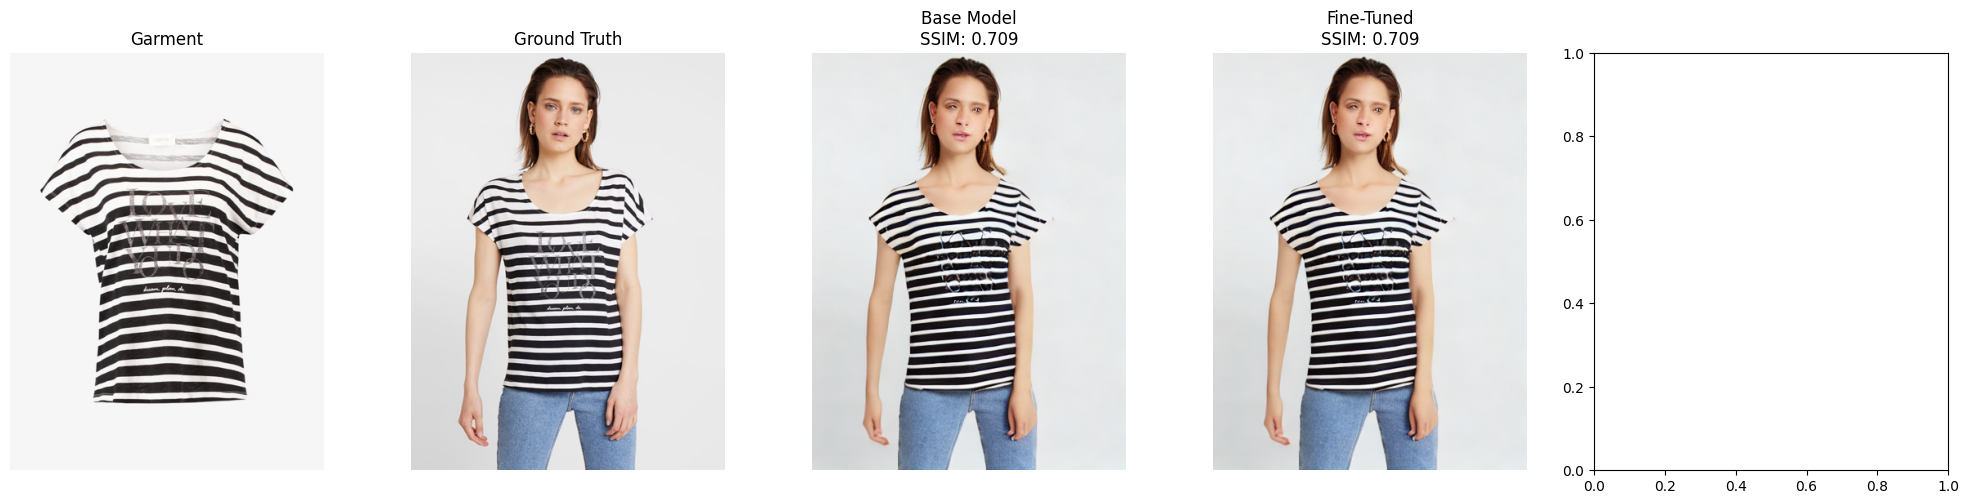

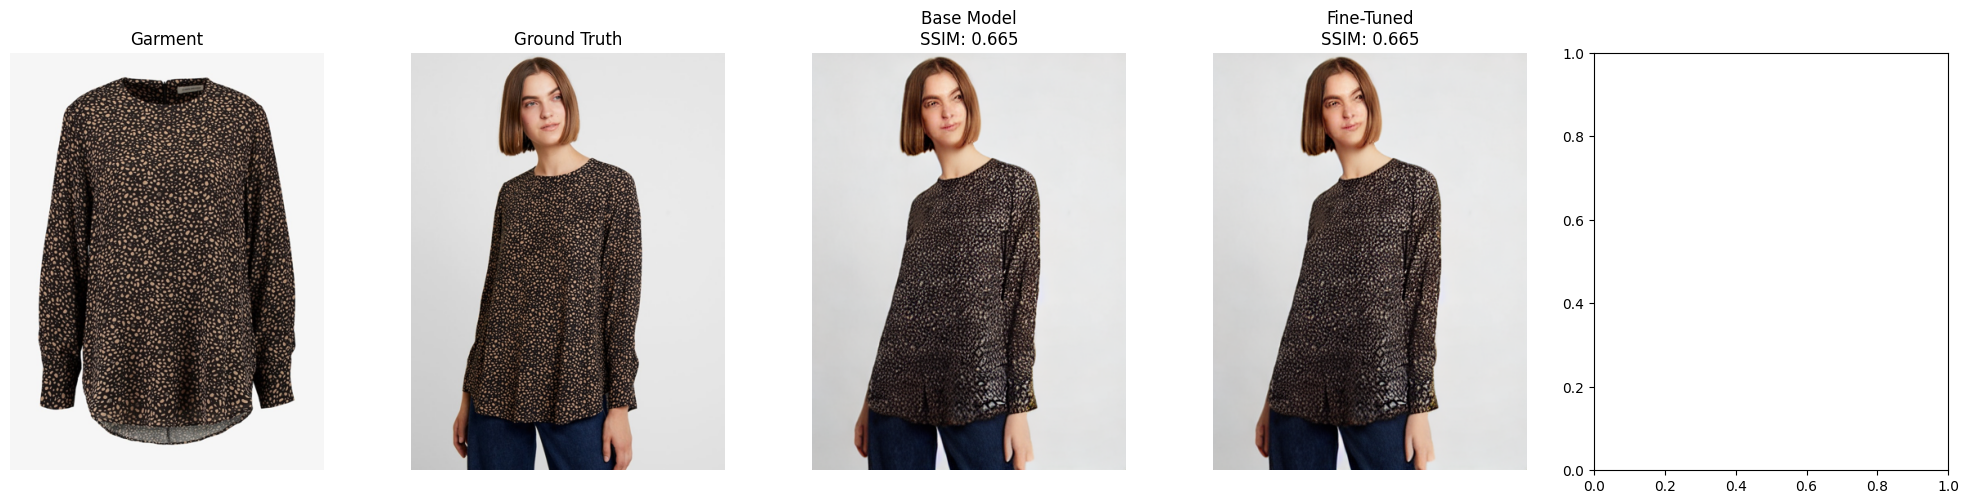

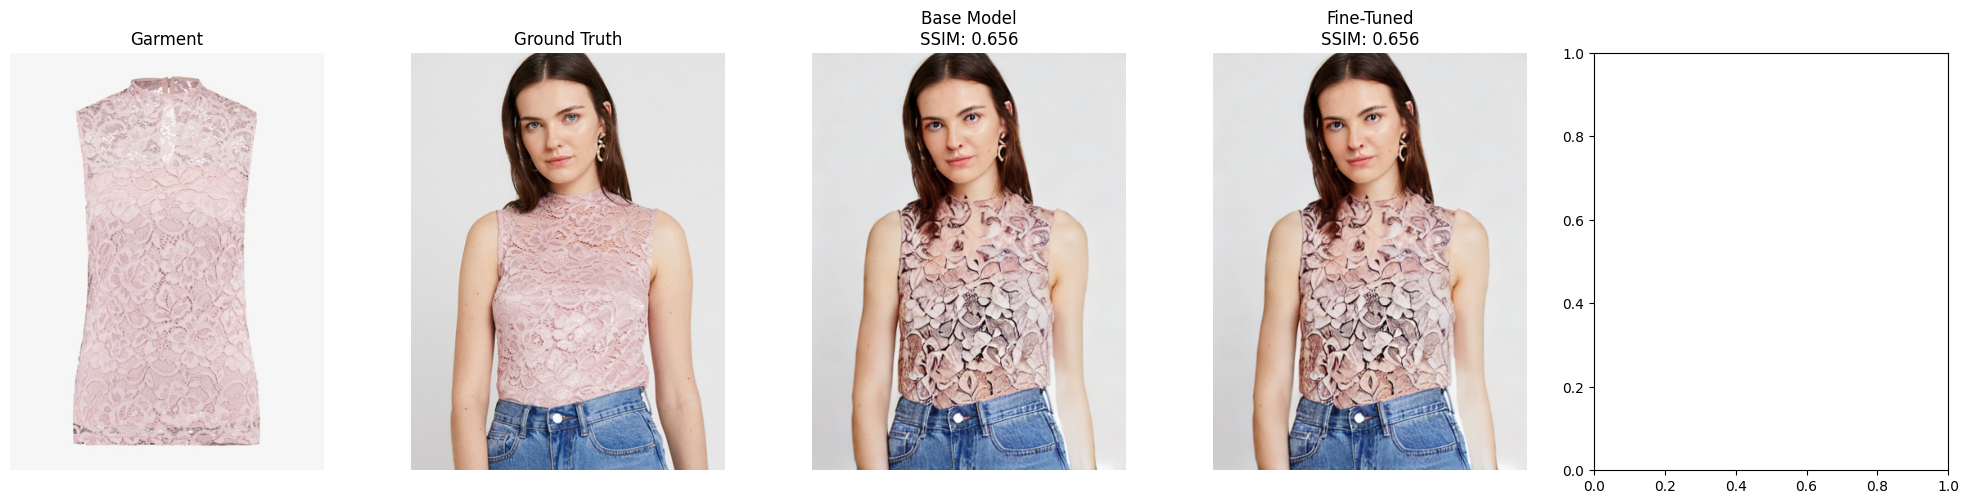

In [ ]:
total_results = len(catvton_base_results)
vis_count = min(3, total_results)
vis_indices = random.sample(range(total_results), vis_count)

for idx in vis_indices:
    res_base = catvton_base_results[idx]
    res_ft = catvton_ft_results[idx]
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    
    # Garment
    axes[0].imshow(res_base['cloth'])
    axes[0].set_title("Garment")
    axes[0].axis('off')
    
    # Target
    axes[1].imshow(res_base['ground_truth'])
    axes[1].set_title("Ground Truth")
    axes[1].axis('off')
    
    # Base Result
    axes[2].imshow(res_base['generated'])
    axes[2].set_title(f"Base Model\nSSIM: {res_base['ssim']:.3f}")
    axes[2].axis('off')
    
    # Fine-Tuned Result
    axes[3].imshow(res_ft['generated'])
    axes[3].set_title(f"Fine-Tuned\nSSIM: {res_ft['ssim']:.3f}")
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()